# UNET SEGMENTATION (SUJAL)

In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data 

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        # Construct image path
        image_path = os.path.join(self.path, "images", id_name)

        # Construct mask path
        mask_path = os.path.join(self.path, "masks", id_name)

        # Read and resize image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        # Read and resize mask
        mask = cv2.imread(mask_path, 0)  # mask often is a single-channel image
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)

        # Normalize
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hyperparameters

In [ ]:
image_size = 128
train_path = "/content/drive/MyDrive/UNet Dataset/Cardiac Dataset/train"
epochs = 30
batch_size = 8

## Training Ids
train_ids = os.listdir(os.path.join(train_path, "images"))


## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


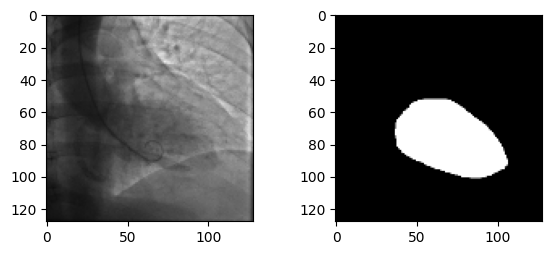

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64
    c2, p2 = down_block(p1, f[1])  # 64  --> 32
    c3, p3 = down_block(p2, f[2])  # 32  --> 16
    c4, p4 = down_block(p3, f[3])  # 16  --> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 256)      │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 256)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 384)    │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 1,962,625 (7.49 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [11]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
          validation_steps=valid_steps, epochs=epochs)

# Save the weights
model.save_weights("UNetW.weights.h5")

# Plot training & validation accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
num_epochs = min(len(acc), len(val_acc))
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(16, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc[:num_epochs], label='Training Accuracy')
plt.plot(epochs_range, val_acc[:num_epochs], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss[:num_epochs], label='Training Loss')
plt.plot(epochs_range, val_loss[:num_epochs], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/213 ━━━━━━━━━━━━━━━━━━━━ 631s 3s/step - acc: 0.8556 - loss: 0.3451 - val_acc: 0.9528 - val_loss: 0.0973
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - acc: 0.9566 - loss: 0.0906 - val_acc: 0.9547 - val_loss: 0.1025
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


213/213 ━━━━━━━━━━━━━━━━━━━━ 215s 727ms/step - acc: 0.9470 - loss: 0.1336 - val_acc: 0.9685 - val_loss: 0.0766
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 156s 735ms/step - acc: 0.9662 - loss: 0.0772 - val_acc: 0.9793 - val_loss: 0.0495
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 110s 516ms/step - acc: 0.9653 - loss: 0.0823 - val_acc: 0.9794 - val_loss: 0.0416
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 155s 725ms/step - acc: 0.9696 - loss: 0.0687
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 158s 741ms/step - acc: 0.9718 - loss: 0.0647 - val_acc: 0.9770 - val_loss: 0.0795
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 103s 484ms/step - acc: 0.9697 - loss: 0.0692 - val_acc: 0.9852 - val_loss: 0.0317
Epoch 9/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 188s 762ms/step - acc: 0.9759 - loss: 0.0537 - val_acc: 0.9818 - val_loss: 0.0413
Epoch 10/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 156s 729ms/step - acc: 0.9766 - loss: 0.0518 - val_acc: 0.9870 - val_loss: 0.0268
Epoch 11/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 106s 495ms/step - acc: 0.9774 

## Testing the model

In [12]:
## Save the Weights
model.save_weights("UNetW.weights.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

result = result > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


In [ ]:

# Load the weights
model.load_weights("UNetW.weights.h5")

# Now you can use the model for predictions or further training
x, y = valid_gen.__getitem__(2)
result = model.predict(x)
result = result > 0.5

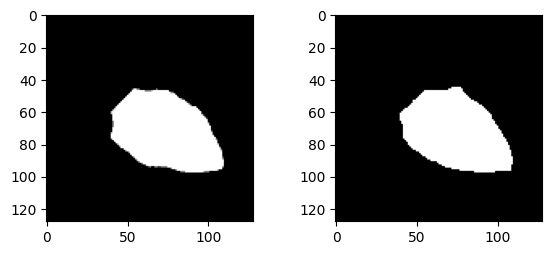

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

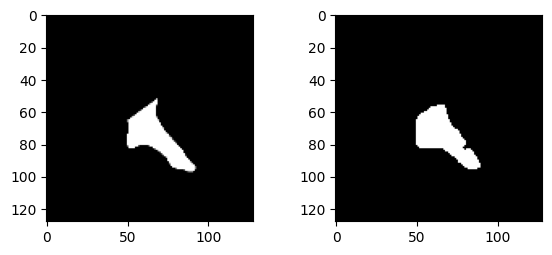

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

# CNN Model (Madhurya)

Dataset shape : (1717, 64, 64, 1) (1717, 32, 32, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 54, 54, 100)         │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 9, 9, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8100)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       8,295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 32, 32, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,307,624 (31.69 MB)

 Trainable params: 8,307,624 (31.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - accuracy: 0.9048 - loss: 0.1698 - val_accuracy: 0.9131 - val_loss: 0.0750
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - accuracy: 0.9424 - loss: 0.0506 - val_accuracy: 0.9195 - val_loss: 0.0692
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - accuracy: 0.9451 - loss: 0.0481 - val_accuracy: 0.9209 - val_loss: 0.0683
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.9532 - loss: 0.0424 - val_accuracy: 0.9235 - val_loss: 0.0640
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 262ms/step - accuracy: 0.9594 - loss: 0.0375 - val_accuracy: 0.9282 - val_loss: 0.0603
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.9649 - loss: 0.0328 - val_accuracy: 0.9348 - val_loss: 0.0550
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 265ms/step - accuracy: 0.9682 - loss: 0.0304 - val_accuracy: 0.9350 - val_loss: 0.0541
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.9701 - loss: 0.0286 - val_accu

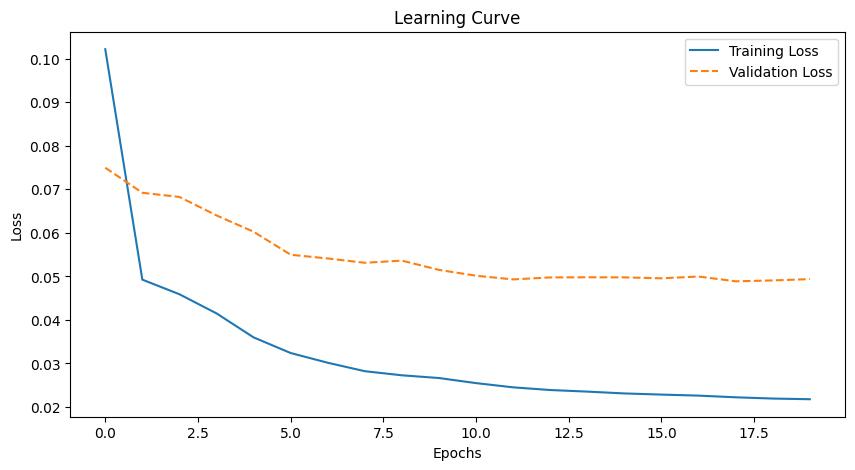

108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step
y_pred shape: (1717, 32, 32, 1)


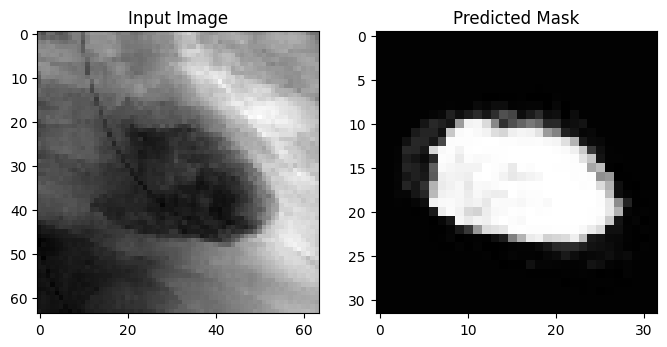

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import regularizers

# Set your data directory
data_dir = '/content/drive/MyDrive/UNet Dataset/Cardiac Dataset/train'
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "masks")

# List files
image_names = sorted(os.listdir(image_dir))
image_names = [name for name in image_names if name in mask_names]
mask_names = sorted(os.listdir(mask_dir))

# Make sure that image_names and mask_names correspond one-to-one
# If they differ, ensure file naming consistency before running.
assert len(image_names) == len(mask_names), "Number of images and masks do not match."

# Desired shapes
input_image_shape = (64, 64)  # For the CNN input
mask_shape = (32, 32)         # For the CNN output

X = []
Y = []

for img_name, msk_name in zip(image_names, mask_names):
    img_path = os.path.join(image_dir, img_name)
    msk_path = os.path.join(mask_dir, msk_name)

    # Read images in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

    # Resize to desired shapes
    img = cv2.resize(img, input_image_shape)
    msk = cv2.resize(msk, mask_shape)

    # Normalize (if you want to normalize)
    img = img.astype(np.float32) / 255.0
    msk = msk.astype(np.float32) / 255.0

    # Add channel dimension
    img = np.expand_dims(img, axis=-1)  # (64,64,1)
    msk = np.expand_dims(msk, axis=-1)  # (32,32,1)

    X.append(img)
    Y.append(msk)

X = np.array(X)
Y = np.array(Y)

print('Dataset shape :', X.shape, Y.shape)  # X: (N,64,64,1), Y: (N,32,32,1)

# Create the CNN model
def create_model(input_shape=(64, 64, 1)):
    """
    Simple convnet model: one convolution, one average pooling and one fully connected layer
    ending with a reshape to (32,32,1).
    """
    model = Sequential()
    # Conv layer
    model.add(Conv2D(100, (11,11), padding='valid', strides=(1, 1), input_shape=input_shape))
    # Average Pooling
    model.add(AveragePooling2D((6,6)))
    # Flatten/Reshape step
    # After Conv+Pool:
    # Input: (64x64x1) -> Conv(11x11): (54x54x100) -> AvgPool(6x6): (9x9x100) = 8100 features
    model.add(Reshape((8100,)))  # Flatten to (8100,)
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    # Now we have (1024,). We want (32,32,1):
    # 32*32 = 1024, so we reshape to (32,32,1)
    model.add(Reshape((32,32,1)))
    return model

m = create_model()
m.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print('Model Summary:')
m.summary()

# Train the model
epochs = 20
batch_size = 16
history = m.fit(X, Y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save the weights
m.save_weights("UNetW.weights.h5")

# Example prediction
y_pred = m.predict(X, batch_size=batch_size)
print("y_pred shape:", y_pred.shape)

# Visualize a sample
idx = 0
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(X[idx].reshape(64,64), cmap='gray')
ax[0].set_title('Input Image')
ax[1].imshow(y_pred[idx].reshape(32,32), cmap='gray')
ax[1].set_title('Predicted Mask')
plt.show()
